# Ising class Correlation

In [2]:
import numpy as np
import scipy
import scipy.signal as signal
import scipy.constants
from scipy.fft import fft2, fftshift
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook
%matplotlib inline
from IPython.display import HTML
import ipywidgets as widgets

from Ising_class import IsingModel
from utils import *

Lorentian : $$L(x) = \frac{A\gamma}{\gamma^2+(x-x_0)^2}$$ $FWHM = 2\gamma$


$$f(x) = e^{-\frac{|x|}{a}}$$

$$TF[f(x)](k) = \frac{2a}{1 + (a k)^2} = \frac{2/a}{1/a^2 + k^2}$$

$$\text{two expressions for $L(x)$} \implies \boxed{a= 1/\gamma} $$

In [3]:
def get_average_PSD(n_samples=1000, N=100, T=3, n_eq=300, plot=True):

    images = np.zeros((n_samples, N, N))

    for i in range(n_samples):
        model = IsingModel(N=N, T=T)
        model.simulate(n_eq, save_data=True)
        images[i] = model.lattice

    PSD = np.zeros((N, N))
    for img in images:
        psd = np.abs( fftshift(fft2(img)) )**2
        PSD += psd

    PSD = PSD / len(images)

    if plot:
        plt.imshow(PSD)
        plt.title('Mean PSD')

    return PSD

In [4]:

def xi_from_PSD(PSD, n_samples, T, N_max_fit=None, A0=None, plot=False):

    # Step 3: Create distance grid
    N = PSD.shape[0]
    x = np.arange(-N//2, N//2)
    y = np.arange(-N//2, N//2)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    # Step 4: Radial averaging
    max_radius = N//2
    radial_profile = np.zeros(max_radius)
    for r in range(max_radius):
        mask = (R >= r) & (R < r + 1)
        radial_profile[r] = PSD[mask].mean()

    def get_symetrise_array(X):
        return np.concatenate([np.flip(X[1:]), [X[0]], X[1:]])

    def get_antisymetrise_array(X):
        return np.concatenate([-np.flip(X[1:]), [X[0]], X[1:]])

    x_data = get_antisymetrise_array(range(max_radius))
    y_data = get_symetrise_array(radial_profile)


    def lorentzian(x, x0, gamma, A):
        return A * (gamma**2) / ((x - x0)**2 + gamma**2)

    # Initial guesses for the parameters
    if A0 is None:
        A0 = np.max(y_data)
    initial_guess = [0, 1, A0]  # Initial guess: [x0, gamma, A]

    # Perform the curve fitting
    if N_max_fit is None:
        N_max_fit = N//2

    i = N//2-N_max_fit
    x_data_fit = x_data[i:-i-1]
    y_data_fit = y_data[i:-i-1]
    params, covariance = curve_fit(lorentzian, x_data_fit, y_data_fit, p0=initial_guess)

    # Extract fitted parameters
    x0_fit, gamma_fit, A_fit = params
    xi = 1/gamma_fit

    print(f"Fitted parameters: x0 = {x0_fit:.4f}, gamma = {gamma_fit:.4f}, A = {A_fit:.4f}")

    # Plotting the results
    if plot:
        y_fit = lorentzian(x_data, x0_fit, gamma_fit, A_fit)

        plt.figure(figsize=(10, 6))
        plt.scatter(x_data, y_data, label='radial average of 2D PSD\n(mean over {} lattices)'.format(n_samples), color='blue', s=10)
        plt.plot(x_data, y_fit, label='Lorentzian Fit', color='red')
        plt.axvline(-N_max_fit, ls='--', color='gray', label='fit range')
        plt.axvline(+N_max_fit, ls='--', color='gray')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(r'Lorentzian Curve Fit, T = {:.3f} ; $\xi = ${:.3f}'.format(T, xi))
        plt.legend()
        plt.grid()
        plt.show()

  
    return xi, x_data, y_data

## Démo pour une température

Fitted parameters: x0 = -0.0002, gamma = 3.7463, A = 27954.6869


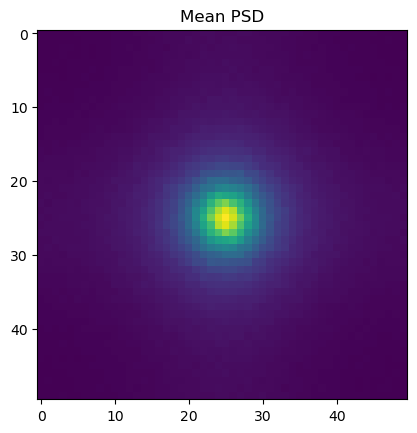

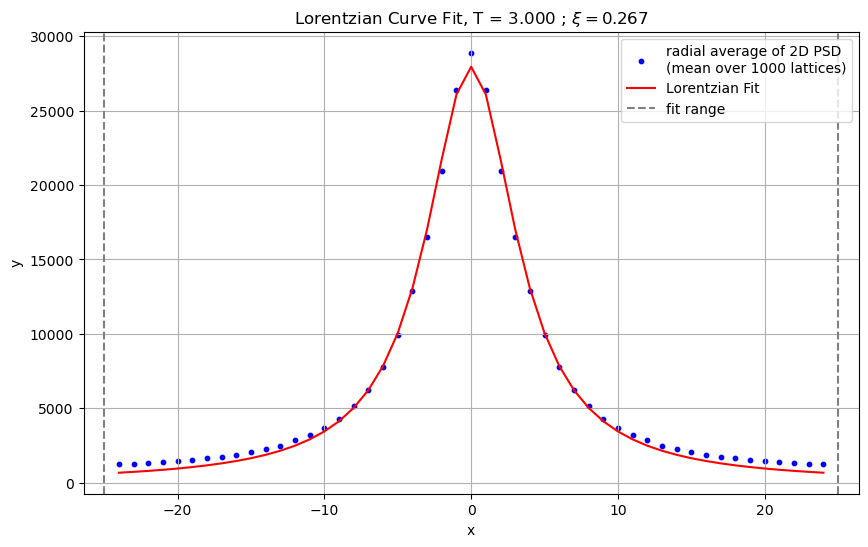

In [73]:
PSD_0 = get_average_PSD(T=3, N=50)
xi, _, _ = xi_from_PSD(PSD_0, n_samples=1000, T=3, plot=True)

## Étude avec la température

Fitted parameters: x0 = 0.0000, gamma = 2.6454, A = 62726.7897
Fitted parameters: x0 = -0.0000, gamma = 2.6496, A = 61252.7343
Fitted parameters: x0 = -0.0000, gamma = 2.7522, A = 54629.3694
Fitted parameters: x0 = -0.0000, gamma = 2.9239, A = 47694.0318
Fitted parameters: x0 = -0.0001, gamma = 3.3672, A = 36113.2297
Fitted parameters: x0 = -0.0002, gamma = 3.9880, A = 27135.5006
Fitted parameters: x0 = -0.0004, gamma = 4.6549, A = 21256.0048
Fitted parameters: x0 = -0.0014, gamma = 6.1081, A = 14544.8065
Fitted parameters: x0 = -0.0042, gamma = 8.3197, A = 10013.6897
Fitted parameters: x0 = -0.0128, gamma = 11.7915, A = 6850.2505
Fitted parameters: x0 = -0.0241, gamma = 14.6810, A = 5553.6786


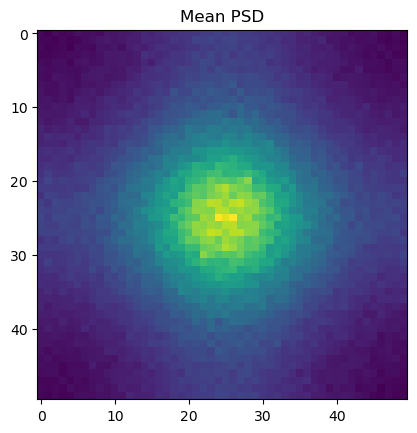

In [71]:
T_list = [2.269, 2.3, 2.4, 2.5, 2.7, 2.9, 3.1, 3.5, 4, 5, 6]
n_samples = 1000
xi_list = []

for T in T_list:

    PSD = get_average_PSD(n_samples=n_samples, N=50, T=T, n_eq=50)
    xi_list.append(xi_from_PSD(PSD, n_samples=n_samples, T=T)[0])

Text(0, 0.5, '$\\xi$')

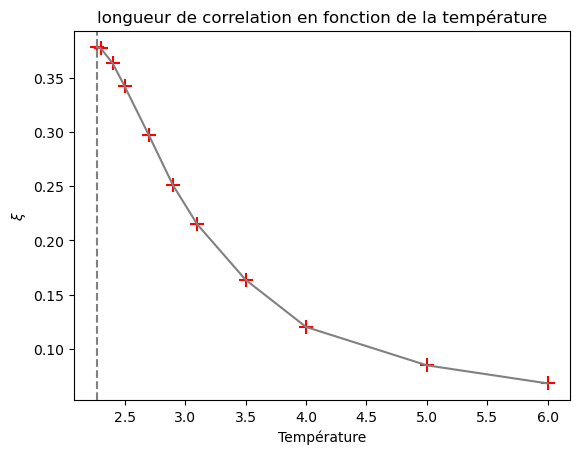

In [74]:
plt.plot(T_list, xi_list, color='gray')
plt.scatter(T_list, xi_list, marker='+', s=100, color='red')
plt.axvline(Tc, ls='--', color='gray')
plt.title(r'longueur de correlation en fonction de la température')
plt.xlabel('Température')
plt.ylabel(r'$\xi$')